In [ ]:
!pip install transformers==4.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 33.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        Source:
            https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [ ]:
logits = torch.tensor([2.0, 1.5, 1.2, 0.5, -0.5, -1.0, -1.5])
filtered_logits = top_k_top_p_filtering(logits.clone(), top_k=10)
filtered_logits

tensor([ 2.0000,  1.5000,  1.2000,  0.5000, -0.5000, -1.0000, -1.5000])

In [ ]:
def sample_token(output):
    logits = output[..., -1, :].squeeze(0)
    logits = top_k_top_p_filtering(logits, top_k=10)
    log_probs = torch.softmax(logits, dim=-1)
    token = torch.multinomial(log_probs, num_samples=1)[0]

    return token

## Transformer-XL

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('transfo-xl-wt103')
model = AutoModelWithLMHead.from_pretrained('transfo-xl-wt103')

`TransfoXL` was deprecated due to security issues linked to `pickle.load` in `TransfoXLTokenizer`. See more details on this model's documentation page: `https://github.com/huggingface/transformers/blob/main/docs/source/en/model_doc/transfo-xl.md`.


ImportError: 
TransfoXLTokenizer requires the sacremoses library but it was not found in your environment. You can install it with pip:
`pip install sacremoses`. Please note that you may need to restart your runtime after installation.


In [ ]:
generated = tokenizer.encode("On our way to the beach")
context = torch.tensor([generated])
past = None

In [ ]:
for i in range(100):
    output = model(context, mems=past)
    token = sample_token(output.prediction_scores)

    generated.append(token.item())
    context = token.view(1, -1)
    past = output.mems

In [ ]:
print(tokenizer.decode(generated))

On our way to the beach on the morning of the weekend of his, <eos> the morning of the Friday the 13th is a very quiet day, and the afternoon of Saturday of the 13th is quite good. "<eos> The day after Monday morning, Saturday afternoon, the afternoon of the 14th, a very quiet day of the 13th, is celebrated with a fireworks display and fireworks. <eos> The day after Saturday, Thursday afternoon, the night of the 14th, the afternoon of Friday is devoted to the celebration. The day is also dedicated to


## GPT-2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
model = AutoModelWithLMHead.from_pretrained('gpt2-large')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
generated = tokenizer.encode("On our way to the beach")
context = torch.tensor([generated])
past = None

In [ ]:
for i in range(100):
    output = model(context, past_key_values=past)
    token = sample_token(output.logits)

    generated.append(token.item())
    context = token.unsqueeze(0)
    past = output.past_key_values

In [ ]:
print(tokenizer.decode(generated))

On our way to the beach we passed an old church, with the ruins of the walls still there. It's not a church, it's a ruin. We could see that the stones were covered with moss and the old wooden pillars were falling down.

The beach was full of people, some were sunbathing and others just relaxing. We saw a little girl and a man sitting on a beach chair, their heads are in the sand. I looked down at the beach and saw that the water was still very cold


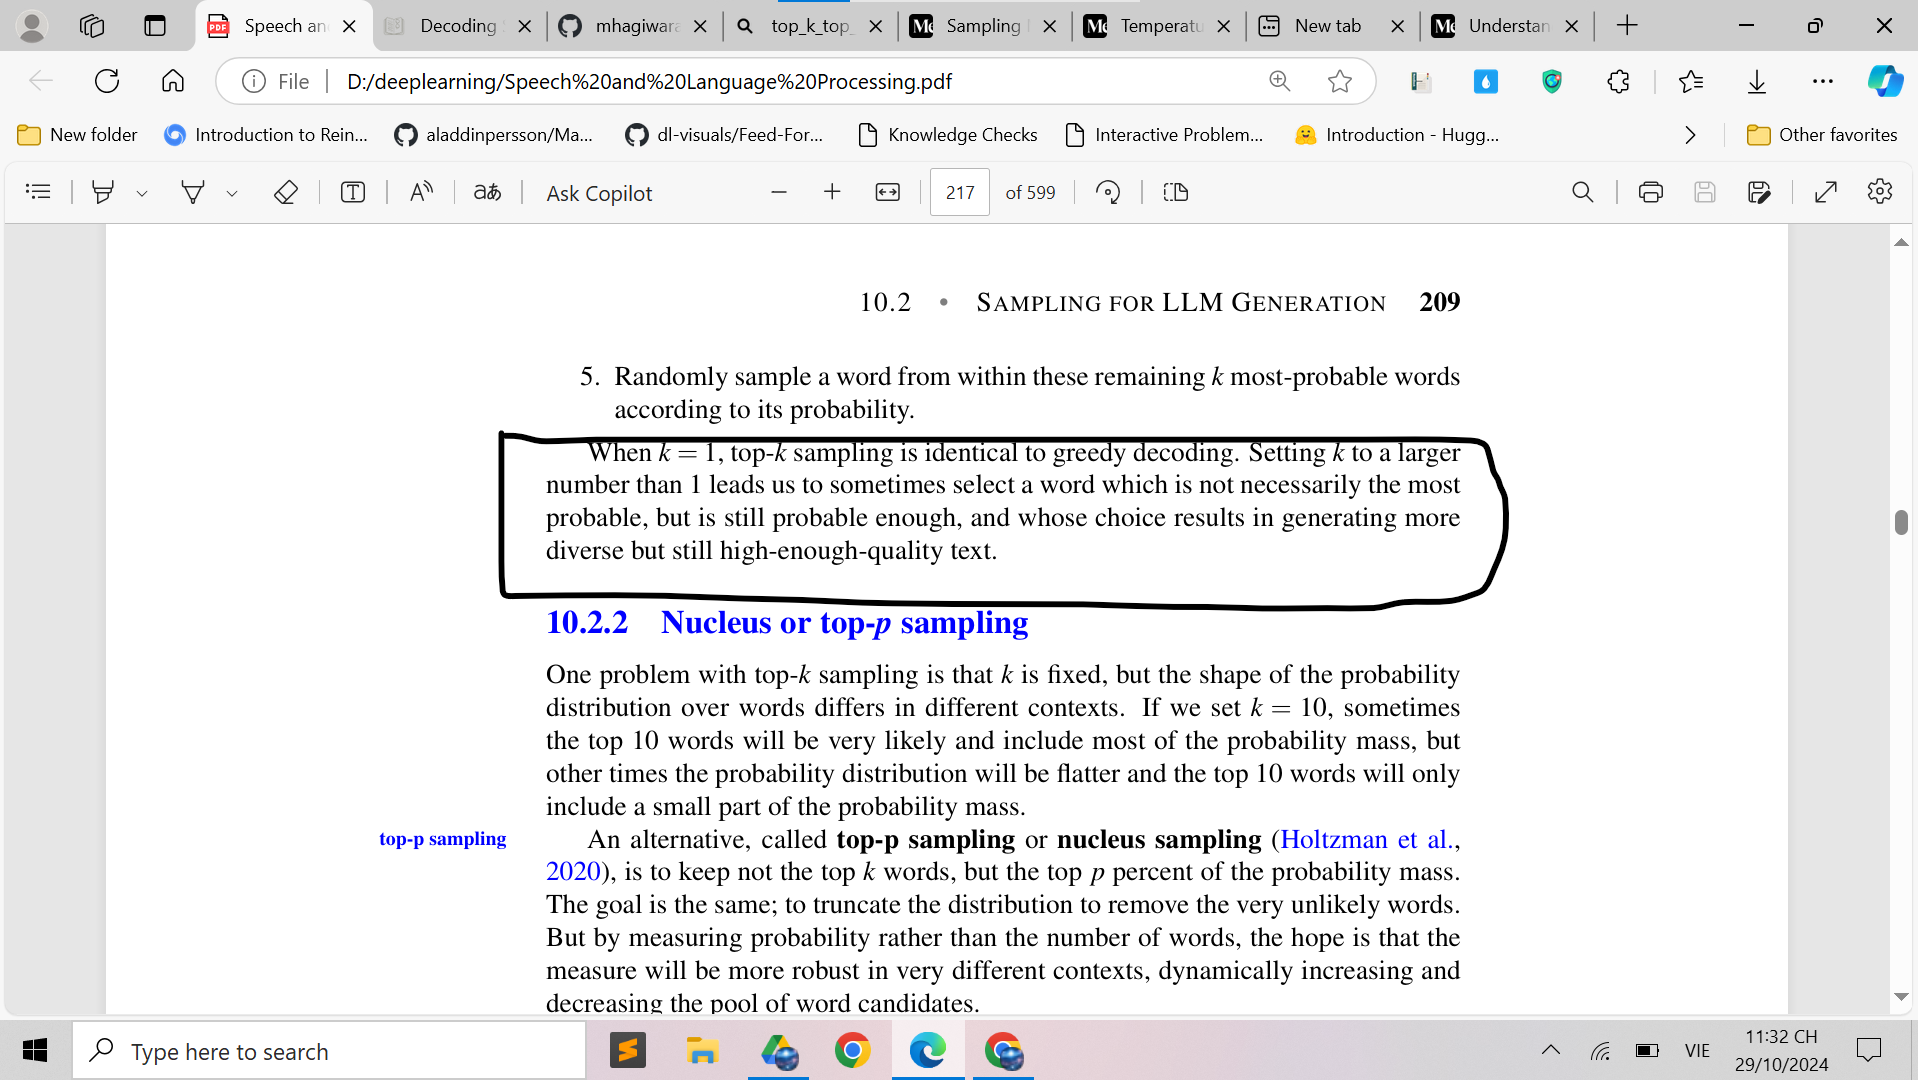

**Khi  k=1 ,  top-k sampling giống như giải mã greedy**. Khi đặt  k  lớn hơn, phương pháp có thể chọn từ không phải là từ có xác suất cao nhất nhưng vẫn có xác suất đủ cao, cho phép tạo ra văn bản đa dạng hơn mà vẫn đảm bảo chất lượng.

In [ ]:
def sample_token_greedy(output):
    logits = output[..., -1, :].squeeze(0)
    logits = top_k_top_p_filtering(logits, top_k=1)
    log_probs = torch.softmax(logits, dim=-1)
    token = torch.multinomial(log_probs, num_samples=1)[0]

    return token


In [ ]:
print(tokenizer.decode(generated))

On our way to the beach we passed an old church, with the ruins of the walls still there. It's not a church, it's a ruin. We could see that the stones were covered with moss and the old wooden pillars were falling down.

The beach was full of people, some were sunbathing and others just relaxing. We saw a little girl and a man sitting on a beach chair, their heads are in the sand. I looked down at the beach and saw that the water was still very cold.

"I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry, I'm sorry,


In [ ]:
for i in range(100):
    output = model(context, past_key_values=past)
    token = sample_token_greedy(output.logits)

    generated.append(token.item())
    context = token.unsqueeze(0)
    past = output.past_key_values

## XLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-clm-enfr-1024')
model = AutoModelWithLMHead.from_pretrained('xlm-clm-enfr-1024')

Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-clm-enfr-1024 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
generated = [0] # start with just <s>
context = torch.tensor([generated])
lang = 0 # English

In [ ]:
for i in range(100):
    langs = torch.zeros_like(context).fill_(lang)
    output = model(context, langs=langs)
    token = sample_token(output.logits)

    generated.append(token.item())
    context = torch.tensor([generated])

In [ ]:
print(tokenizer.decode(generated))

<s>, and is a key driver of our financial results. " </s>" But we have made the decision to take it very carefully and that will be based on the best available evidence, " Mr Hunt said. " </s>" We are looking at it. </s>It's been a difficult decision. </s>It's not about a lack of resources, " he said. </s>The fact is that we're going to take the right decision. </s>He's the right time in his situation. </s>" He's


In [ ]:
generated = [0] # start with just <s>
context = torch.tensor([generated])
lang = 1 # French

In [ ]:
for i in range(100):
    langs = torch.zeros_like(context).fill_(lang)
    output = model(context, langs=langs)
    token = sample_token(output.logits)

    generated.append(token.item())
    context = torch.tensor([generated])

In [ ]:
print(tokenizer.decode(generated))

<s>for the U.S. market. </s>C' est un peu comme les années précédentes, il y a des années. </s>" Il fallait faire du théâtre. </s>Les prix. </s>La situation est différente. </s>Il a également été un peu plus difficile pour les banques ". </s>Le comité : pour les banques. </s>La commune, le maire, le syndicat des commerçants... </s>A la maison de retraite, les services municipaux... le conseil municipal, la mairie, c' étaient les services de la mairie, qui
